<a href="https://colab.research.google.com/github/krishnakaushik25/handwritten_digit_recognizer-DL/blob/master/resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Activation, Input, Conv2D, Add, Flatten, AveragePooling2D, Dense, Dropout, BatchNormalization
from keras.utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
import h5py

In [ ]:
train = pd.read_csv("/content/drive/My Drive/train.csv")
test = pd.read_csv("/content/drive/My Drive/test.csv")
sample = pd.read_csv("/content/drive/My Drive/sample_submission.csv")

In [ ]:
train.describe()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.00000,42000.000000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,...,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0
mean,4.456643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00300,0.011190,0.005143,0.000214,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000381,0.001310,0.010548,0.027262,0.050905,0.066405,0.129571,...,3.772524,2.748905,1.796452,1.089905,0.563190,0.239571,0.093524,0.024833,0.000857,0.001405,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.006143,0.035833,0.082357,0.114905,0.178714,0.301452,0.413643,0.513667,0.558833,0.677857,0.60281,0.489238,0.340214,0.219286,0.117095,0.059024,0.02019,0.017238,0.002857,0.0,0.0,0.0,0.0
std,2.887730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.56812,1.626927,1.053972,0.043916,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.078072,0.232634,1.131661,2.310396,3.121847,3.259128,4.992894,...,26.957829,22.879248,18.595109,14.434439,10.517823,6.469315,3.976306,1.846016,0.139556,0.287891,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.949803,2.350859,3.934280,4.543583,5.856772,7.219742,8.928286,10.004069,10.129595,11.254931,10.69603,9.480066,7.950251,6.312890,4.633819,3.274488,1.75987,1.894498,0.414264,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [ ]:
X = train.drop("label", axis = 1).values.reshape(-1, 28, 28, 1)
y = train["label"].values

test = test.values.reshape(-1, 28, 28, 1)

def normalize(data):
    return (data/255)

X = normalize(X)
test = normalize(test) 

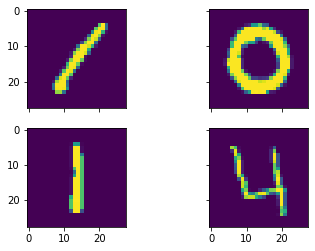

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex = True, sharey = True)
axs = [ax1, ax2, ax3, ax4]
for i in range(len(axs)):
    axs[i].imshow(X[i][:, :, 0])

Resnet Architecture

In [ ]:
def blocks(x, strides, filters):
    y = x
    
    x = Conv2D(filters, kernel_size = 3, padding = "same", strides = strides)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    x = Conv2D(filters, kernel_size = 3, padding = "same", strides = (1, 1))(x)
    x = BatchNormalization()(x)
    
    
    if strides[0] > 1:
        y = Conv2D(filters, kernel_size = 3, padding = "same", strides = strides)(y)
        y = BatchNormalization()(y)
        
    x = Add()([x, y])
    return x

In [ ]:
def residual_net(input_shape, num_classes, filters, blks):
    inputs = Input(input_shape)
    x = Conv2D(filters, kernel_size = 7, padding = "same", strides = (1, 1))(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    # Adding residual blocks
    for block in blks:
        x = blocks(x, strides = (2, 2), filters = filters)
        for i in range(block - 1):
            x = blocks(x, strides = (1, 1), filters = filters)
        filters *= 2
        
    x = AveragePooling2D(4)(x)
    x = Flatten()(x)
    x = Dropout(0.3)(x)
    x = Dense(int(filters/4), activation='relu')(x)
    outputs = Dense(10, activation='softmax')(x)
    
    # Instantiate model
    model = Model(inputs=inputs, outputs=outputs)
    return model      

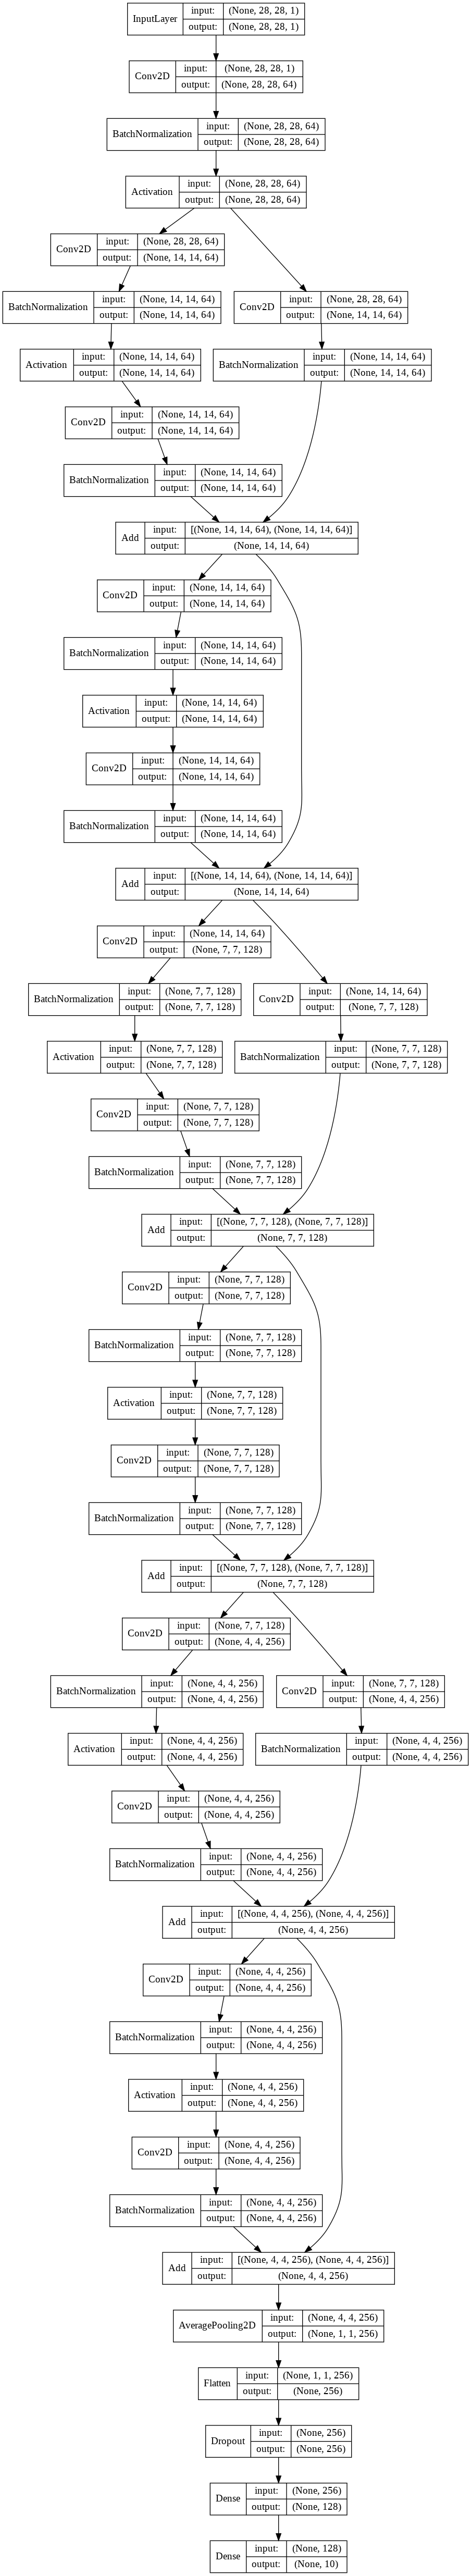

In [ ]:
model = residual_net(
    input_shape=X[0].shape, 
    num_classes=np.unique(y).shape[-1], 
    filters=64, 
    blks=[2,2,2]
)
resnet_architecture = plot_model(model, show_shapes=True, show_layer_names=False)
resnet_architecture.width = 600
resnet_architecture

In [ ]:
def train(epochs, batch_size, i):
    model = residual_net(
    input_shape=X[0].shape, 
    num_classes=np.unique(y).shape[-1], 
    filters=64, 
    blks=[3,3,3])
    
    model.compile(loss = "sparse_categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])
    
    checkpoint = ModelCheckpoint(
    filepath=f'resnet-{i}.hdf5',
    monitor='loss',
    save_best_only=True
    )
    def scheduler(epoch):
        return 0.001 * 0.8**epoch
    schedule = LearningRateScheduler(scheduler)
    callbacks = [checkpoint, schedule]
    
    train_datagen = ImageDataGenerator(  
        rotation_range=10,  
        zoom_range=0.1, 
        width_shift_range=0.1, 
        height_shift_range=0.1)
    
    train_datagen.fit(X)

    # Fit model
    history = model.fit_generator(
        train_datagen.flow(X, y, batch_size=batch_size),
        epochs=epochs, 
        verbose=2, 
        callbacks=callbacks)
    
    return history, model
    

In [ ]:
models = []
all_history = []
for i in range(5):
    print("#"*20)
    print(f"Model number {i + 1}")
    print("#"*20)
    
    history, model = train(
        epochs=12,
        batch_size=128, i = i)
    
    models.append(model)
    all_history.append(history)

####################
Model number 1
####################
Epoch 1/12
 - 81s - loss: 0.2241 - accuracy: 0.9300
Epoch 2/12
 - 70s - loss: 0.0770 - accuracy: 0.9769
Epoch 3/12
 - 69s - loss: 0.0545 - accuracy: 0.9831
Epoch 4/12
 - 69s - loss: 0.0431 - accuracy: 0.9866
Epoch 5/12
 - 69s - loss: 0.0342 - accuracy: 0.9892
Epoch 6/12
 - 69s - loss: 0.0318 - accuracy: 0.9905
Epoch 7/12
 - 69s - loss: 0.0266 - accuracy: 0.9924
Epoch 8/12
 - 69s - loss: 0.0223 - accuracy: 0.9929
Epoch 9/12
 - 69s - loss: 0.0208 - accuracy: 0.9931
Epoch 10/12
 - 70s - loss: 0.0167 - accuracy: 0.9948
Epoch 11/12
 - 70s - loss: 0.0157 - accuracy: 0.9952
Epoch 12/12
 - 70s - loss: 0.0140 - accuracy: 0.9954
####################
Model number 2
####################
Epoch 1/12
 - 75s - loss: 0.2324 - accuracy: 0.9273
Epoch 2/12
 - 69s - loss: 0.0714 - accuracy: 0.9777
Epoch 3/12
 - 69s - loss: 0.0577 - accuracy: 0.9827
Epoch 4/12
 - 69s - loss: 0.0421 - accuracy: 0.9870
Epoch 5/12
 - 69s - loss: 0.0352 - accuracy: 0.9889

In [ ]:
preds = []
for model in models:
    preds.append(model.predict(test))

In [ ]:
f_pred = np.zeros(preds[0].shape)
for p in preds:
    f_pred = f_pred + p
    
preds_mean = (f_pred)/5

In [ ]:
predictions = np.argmax(preds_mean, axis=1)

In [ ]:
result = pd.Series(predictions, name = "Label")
sample["Label"] = result
sample.set_index("ImageId", inplace = True)
sample.to_csv("submission_resnet.csv")